# Cross validation

Il est acquis qu'un modèle doit être évalué sur une base de test différente de celle utilisée pour l'apprentissage. Mais la performance est peut-être juste l'effet d'une aubaine et d'un découpage particulièrement avantageux. Pour être sûr que le modèle est robuste, on recommence plusieurs fois. On appelle cela la validation croisée ou [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

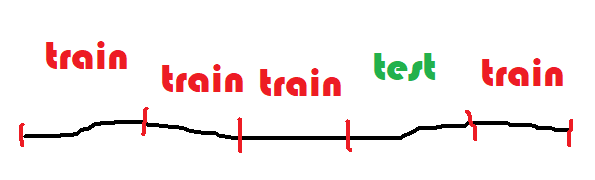

In [1]:
from pyquickhelper.helpgen import NbImage
NbImage('images/cross.png', width=300)

On découpe la base de données en cinq segments de façon aléatoire. On en utilise 4 pour l'apprentissage et 1 pour tester. On recommander 5 fois. Si le modèle est robuste, les cinq de scores de test seront sensiblement égaux.

In [2]:
%matplotlib inline

In [3]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']

On utilise un modèle des plus proches voisins.

In [4]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1)

Nous allons utiliser la fonction [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [5]:
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X, y, cv=5)

array([-0.83897083, -0.4670711 , -0.59014921, -0.38119203, -0.77196458])

Le score par défaut est $R^2$ :

In [6]:
from sklearn.metrics import make_scorer, r2_score
cross_val_score(knn, X, y, cv=5, scoring=make_scorer(r2_score))

array([-0.83897083, -0.4670711 , -0.59014921, -0.38119203, -0.77196458])

Si on souhaite utiliser score un autre score :

In [7]:
from sklearn.metrics import mean_squared_error
cross_val_score(knn, X, y, cv=5, scoring=make_scorer(mean_squared_error))

array([1.21615385, 1.21230769, 1.27328714, 1.14857583, 1.13702848])

Ou plusieurs à la fois :

In [8]:
from sklearn.model_selection import cross_validate
cross_validate(knn, X, y, cv=5, scoring=dict(r2=make_scorer(r2_score), e2=make_scorer(mean_squared_error)),
              return_train_score=False)

{'fit_time': array([0.01002598, 0.0070138 , 0.01204014, 0.02006769, 0.02206016]),
 'score_time': array([0.02105594, 0.02205825, 0.02419019, 0.05413795, 0.05314612]),
 'test_e2': array([1.21615385, 1.21230769, 1.27328714, 1.14857583, 1.13702848]),
 'test_r2': array([-0.83897083, -0.4670711 , -0.59014921, -0.38119203, -0.77196458])}

On obtient bien les mêmes résultats mais ils sont bien différents de ceux obtenus avec [train_est_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
r2_score(y_test, prediction)

-0.14129772898974946

Ca doit mettre la **puce à l'oreille**. De plus, étonnamment, le score $R^2$ est identique pour les tirages. C'est quelque peu suspect pour un nombre aussi volatile. Cela ne peut être dû au fait que la fonction fait exactement les mêmes découpages. Mettons un peu plus d'aléatoire :

In [10]:
from sklearn.model_selection import StratifiedKFold
from time import clock
res = cross_validate(knn, X, y,
               scoring=dict(r2=make_scorer(r2_score), e2=make_scorer(mean_squared_error)),
               return_train_score=False, 
               cv=StratifiedKFold(n_splits=5, random_state=int(clock()*100), shuffle=True))
res

{'fit_time': array([0.00835943, 0.00901461, 0.00900078, 0.0100224 , 0.00999117]),
 'score_time': array([0.02342367, 0.01907754, 0.02409196, 0.02306008, 0.03409243]),
 'test_e2': array([0.75345622, 0.75230769, 0.82230769, 0.83744222, 0.77563608]),
 'test_r2': array([ 0.01492123,  0.01462866, -0.07705722, -0.10121569, -0.02060161])}

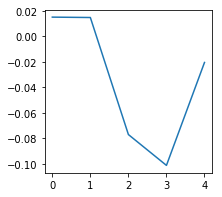

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(res['test_r2']);

On retrouve les mêmes scores que pour [train_est_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Comment l'interpréter ? Et si les vins n'étaient pas mélangées dans la base avec des vins rouges au début et blancs vers la fin.

In [12]:
dfi = df.reset_index(drop=False)
import pandas
pandas.concat([dfi[['index', 'color']].head(), dfi[['index', 'color']].tail()])

,index,color
0,0,red
1,1,red
2,2,red
3,3,red
4,4,red
6492,6492,white
6493,6493,white
6494,6494,white
6495,6495,white
6496,6496,white


In [13]:
dfi[['index', 'color']].groupby('color').min()

,index
color,
red,0
white,1599


In [14]:
dfi[['index', 'color']].groupby('color').max()

,index
color,
red,1598
white,6496


Les éléments sont clairements triés par couleur et la validation croisée par défaut découpe selon cet ordre. Cela signifie presque que le modèle essaye de prédire la note d'un vin rouge en s'appuyant sur des vins blancs et cela ne marche visiblement pas.